# Wzy Protein Structural Analysis

## Setup

### Define file paths

In [1]:
from pathlib import Path
parent_path = Path('/Users/tsta0015/Programming/Wzy_Analysis')
jk_path = parent_path / 'from_JK'
pc_path = jk_path / 'ProteinCartography'
foldseek_path = parent_path / 'foldseek'
search_scores = foldseek_path / 'search_tmscores.tsv.zst'
af3_path = parent_path / 'af3'
models_path = af3_path / 'cif'
summary_json_path = af3_path / 'json'
result_path = parent_path / 'results'

### Define fasta parsing function

In [2]:
from itertools import chain
def parse_fasta(file: Path):
    with open(file, 'rt') as handle:
        header, line_buffer, record = '', [], None
        for line in chain(handle, ['>']):
            if not (line := line.strip()):
                continue
            if line.startswith('>'):
                if header and line_buffer:
                    name, _, _ = header.partition(' ')
                    yield name, ''.join(line_buffer)
                header, line_buffer = line[1:], []
            else:
                line_buffer.append(line)

### Load ground truths

In [3]:
import pandas as pd
import numpy as np
# Set the option to avoid future warnings
pd.set_option('future.no_silent_downcasting', True)
# Create the base DataFrame with an outer join
# noinspection PyNoneFunctionAssignment
truths = pd.DataFrame.from_records(
    [(i.lower(), f.stem) for f in jk_path.glob('*.faa') for i, _ in parse_fasta(f)],
    columns=['ID', 'Truth'], index='ID'
).join(
     pd.DataFrame({'Model': True}, [i.stem for i in models_path.glob('*.cif')]),
    how='outer'
).fillna({'Model': False})
# Fill NaN values in the 'Truth' column based on the index
# Create a boolean mask for the rows where 'Truth' is NaN
na_mask = truths['Truth'].isna()
# Apply the new values to the 'Truth' column where it was NaN
truths.loc[na_mask, 'Truth'] = np.where(
    truths.index[na_mask].str.contains('seed', case=False),
    'HMM Seed', 'Missing'
)

#### Write to file

In [4]:
truths.to_csv(result_path / 'structure_truths.csv.zst', index_label='ID', compression='zstd')

### Define matrix loading function

In [5]:
from scipy.sparse import coo_matrix
import pandas as pd

def load_scores(path: Path, sep=r'\s+'):
    """Function to load TM-Scores as a sparse matrix using pandas for faster parsing."""
    # Use pandas to read the file, which is much faster for large files.
    # We only need the first 3 columns.
    df = pd.read_csv(
        path,
        sep=sep,
        header=None,
        usecols=[0, 1, 2],
        names=['query', 'target', 'weight'],
        engine='c'  # Explicitly use the faster C engine
    )

    # Create a mapping from unique labels to integer indices
    labels = pd.unique(df[['query', 'target']].values.ravel('K'))
    index_map = {label: i for i, label in enumerate(labels)}

    # Map the query and target columns to their integer indices
    rows = df['query'].map(index_map)
    cols = df['target'].map(index_map)
    data = df['weight']

    # Create the sparse matrix
    n = len(labels)
    M = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()

    # Symmetrize the graph, which is common practice.
    return labels, M.maximum(M.T)

## Generating Wzy 3D Structures

### Prepare AlphaFold3 JSON input files
We use the `generate_af3_json.py` script to generate JSON files as an input to AlphaFold3. This script accepts protein sequences in FASTA format, and generates one JSON file per sequence as per the AF3 documentation.

```shell
scripts/generate_af3_json.py fastas/*.faa -o json
```

### Run AlphaFold3

```shell
for i in json/*.json;
    do sbatch -p gpu --gres=gpu:1 -t 20 -n 1 -c 8 \
    --wrap "module load alphafold/3.0.0; run_alphafold.py --json_path=${i} --output_dir=results && mv ${i} completed/";
done
```

### Model summary confidences

In [6]:
from json import loads as json_loads
import pandas as pd
summary_confidences = pd.DataFrame.from_dict(
    {i.stem.removesuffix('_summary_confidences'): json_loads(i.read_text()) for i in summary_json_path.iterdir()},
    orient='index'
).join(truths)
summary_confidences = summary_confidences.loc[:,~summary_confidences.columns.str.startswith(('chain', 'iptm'))]

In [7]:
summary_confidences[['ptm', 'ranking_score', 'fraction_disordered']].describe().round(2)

,ptm,ranking_score,fraction_disordered
count,925.00,925.00,925.00
mean,0.90,0.91,0.01
std,0.04,0.03,0.02
min,0.46,0.47,0.00
25%,0.89,0.90,0.00
50%,0.91,0.92,0.00
75%,0.92,0.93,0.02
max,0.95,0.96,0.10


In [8]:
summary_confidences[summary_confidences.index.str.startswith('abau')]  \
    [['ptm', 'ranking_score', 'fraction_disordered']].describe().round(2)

,ptm,ranking_score,fraction_disordered
count,248.00,248.00,248.00
mean,0.91,0.92,0.01
std,0.02,0.02,0.02
min,0.85,0.85,0.00
25%,0.90,0.91,0.00
50%,0.91,0.92,0.00
75%,0.93,0.93,0.02
max,0.95,0.95,0.08


In [9]:
summary_confidences[~summary_confidences.index.str.startswith('abau')] \
    [['ptm', 'ranking_score', 'fraction_disordered']].describe().round(2)

,ptm,ranking_score,fraction_disordered
count,677.00,677.00,677.00
mean,0.90,0.91,0.01
std,0.04,0.04,0.02
min,0.46,0.47,0.00
25%,0.89,0.90,0.00
50%,0.91,0.91,0.00
75%,0.92,0.92,0.02
max,0.95,0.96,0.10


#### Write to file

In [10]:
summary_confidences.to_csv(result_path / 'summary_confidences.csv.zst', index_label='ID', compression='zstd')

## Clustering Wzy 3D Structures
Replicating the ProteinCartography pipeline


### Run Foldseek

First, we run Foldseek in the same manner as the ProteinCartography pipeline

```shell
foldseek createdb cif/*.cif DB  # Create the Wzy structure database
foldseek search DB DB search_result tmp -a  # Align the sequences to each other and request a backtrace
foldseek aln2tmscore DB DB search_result search_tmscore  # Compute the TM-Score from the alignment backtrace
foldseek createtsv DB DB search_tmscore search_tmscores.tsv  # Convert the scores to tabular format
foldseek clust DB search_result cluster_result
foldseek createtsv DB DB cluster_result cluster_result.tsv
```

### Leiden Clustering and UMAP projection

In [8]:
from sknetwork.clustering import Leiden
from sklearn.manifold import SpectralEmbedding
from umap import UMAP
import warnings

# Load scores
labels, M = load_scores(search_scores)

M_reduced = SpectralEmbedding(affinity='precomputed', random_state=42).fit_transform(M)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    embedding = UMAP(random_state=42).fit_transform(M_reduced)

results = pd.DataFrame(
    index=labels,
    data={'UMAP 1': embedding[:, 0], 'UMAP 2': embedding[:, 1],
          'Leiden Cluster': [str(c + 1) for c in Leiden().fit_predict(M)]}
).join(truths)
results['Assigned Leiden'] = results.groupby('Leiden Cluster')['Truth'].transform(lambda x: x.mode()[0])

/Users/tsta0015/Programming/Wzy_Analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Plot projections

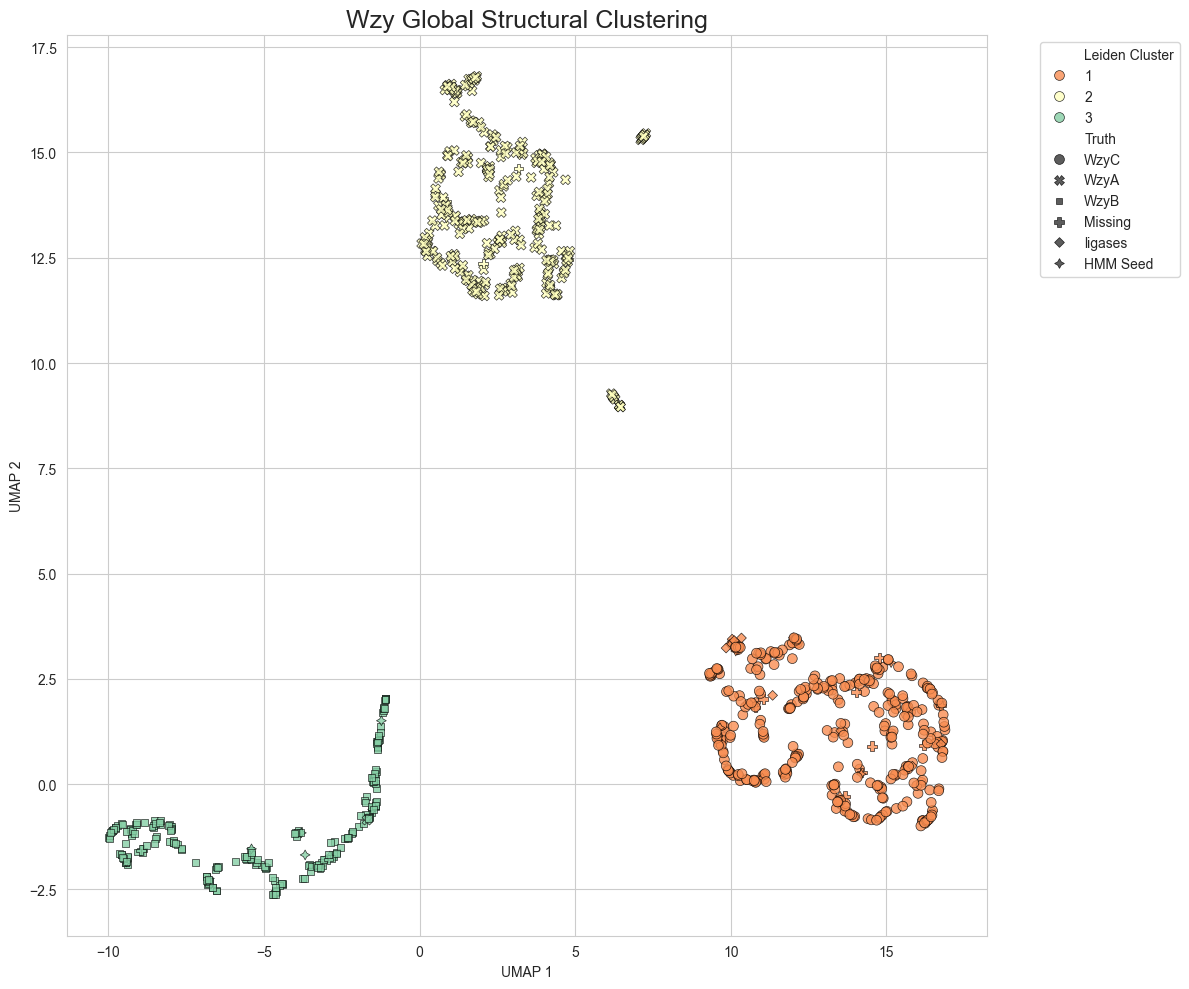

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=results,
    x='UMAP 1',
    y='UMAP 2',
    hue='Leiden Cluster',      # Color points by Leiden cluster
    style='Truth',     # Shape points by ground truth
    palette='Spectral',
    s=50,              # Increased size for better visibility of shapes
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8
)
plt.title('Wzy Global Structural Clustering', fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.tight_layout() # Adjust plot to prevent legend from being cut off
plt.show()

#### Check out mismatches with ProteinCartography ground truth

In [13]:
results[results['Truth'] != results['Assigned Leiden']].groupby('Truth')['Assigned Leiden'].value_counts().unstack(fill_value=0)

Assigned Leiden,WzyA,WzyB,WzyC
Truth,,,
HMM Seed,1,8,8
Missing,5,3,12
WzyA,0,1,0
ligases,1,0,15


### Ward hierarchical clustering

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
k = 3
Z = linkage(squareform(1 - M.todense()), method='ward')
results['Ward Cluster'] = [str(i) for i in fcluster(Z, k, criterion='maxclust')]
results['Assigned Ward'] = results.groupby('Ward Cluster')['Truth'].transform(lambda x: x.mode()[0])

#### Plot HC dendrogram

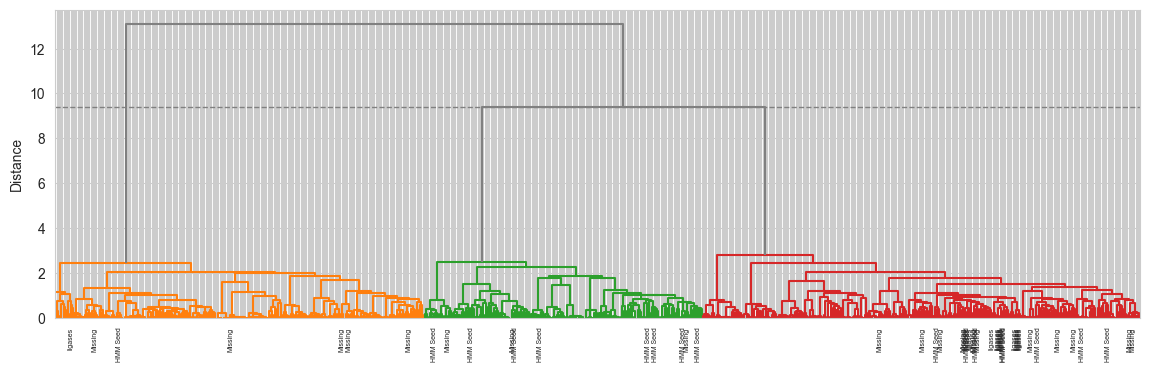

In [15]:
import numpy as np
plt.figure(figsize=(14, 4))
plt.ylabel('Distance')
ax = plt.gca()
dendrogram(
    Z,
    color_threshold=(threshold := Z[-(k-1), 2]),
    above_threshold_color='grey',
    labels=np.where(results['Truth'] != results['Assigned Ward'],  results['Truth'], ''),
    ax=ax
)
plt.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
# Set the background of the figure and axes to be transparent
plt.gcf().patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

#### Check out mismatches with ProteinCartography ground truth

In [10]:
results[results['Truth'] != results['Assigned Ward']].groupby('Truth')['Assigned Ward'].value_counts().unstack(fill_value=0)

Assigned Ward,WzyA,WzyB,WzyC
Truth,,,
HMM Seed,1,8,8
Missing,5,3,12
ligases,1,0,15


#### Check out mismatches with Assigned Leiden

In [17]:
results[results['Assigned Ward'] != results['Assigned Leiden']]

,UMAP 1,UMAP 2,Leiden Cluster,Truth,Model,Assigned Leiden,Ward Cluster,Assigned Ward
proteus_o9_axy99400.1,-1.689849,-0.853043,3,WzyA,True,WzyB,1,WzyA


#### Write to file

In [18]:
results.to_csv(result_path / 'structural_clustering_results.csv.zst', index_label='ID', compression='zstd')

### Pairwise TM-Score Statistics Between Truth Groups

#### Define a function to extact group vs group tm scores

In [11]:
def pairwise_score_per_group(df, group, score_matrix, labs):
    label_to_idx = {label: i for i, label in enumerate(labs)}
    idx_series = pd.Series([label_to_idx[i] for i in df.index], index=df.index)
    group_indices = idx_series.groupby(df[group]).agg(list)
    unique_groups = df[group].unique()
    for group_a in unique_groups:
        for group_b in unique_groups:
            indices_a, indices_b = group_indices[group_a], group_indices[group_b]
            sub_matrix = score_matrix[indices_a, :][:, indices_b].toarray()
            if group_a == group_b:
                # Intra-group: use upper triangle to avoid self-hits and duplicates
                if len(indices_a) > 1:
                    scores = sub_matrix[np.triu_indices_from(sub_matrix, k=1)]
                else:
                    scores = np.array([])
            else:  # Inter-group: flatten the whole submatrix
                scores = sub_matrix.flatten()
            yield {'TM-score': scores, 'Query': group_a, 'Target': group_b}

#### Run the pairwise group score function

In [12]:
import pandas as pd
target_groups = ['WzyA', 'WzyB', 'WzyC', 'ligases']
filtered_results = results[results['Truth'].isin(target_groups)]
group_scores = pd.DataFrame(pairwise_score_per_group(filtered_results, 'Truth', M, labels))

#### Calculate summary statistics for each group comparison


In [15]:
import numpy as np
group_score_summary = pd.concat(
    [
        group_scores[['Query', 'Target']],
        group_scores['TM-score'].apply(lambda scores: pd.Series({
     'mean': np.mean(scores), 'std': np.std(scores), 'min': np.min(scores), 'max': np.max(scores)}))
    ], axis=1)

In [22]:
group_score_summary[(group_score_summary['Query'] != group_score_summary['Target']) & (group_score_summary['Query'] != 'ligases') & (group_score_summary['Target'] != 'ligases')]

,Query,Target,mean,std,min,max
1,WzyC,WzyA,0.196605,0.068557,0.0,0.4378
2,WzyC,WzyB,0.280251,0.060005,0.0,0.5053
4,WzyA,WzyC,0.196605,0.068557,0.0,0.4378
6,WzyA,WzyB,0.154010,0.055462,0.0,0.3621
8,WzyB,WzyC,0.280251,0.060005,0.0,0.5053
9,WzyB,WzyA,0.154010,0.055462,0.0,0.3621


#### Plot pairwise TM-score distributions for selected groups

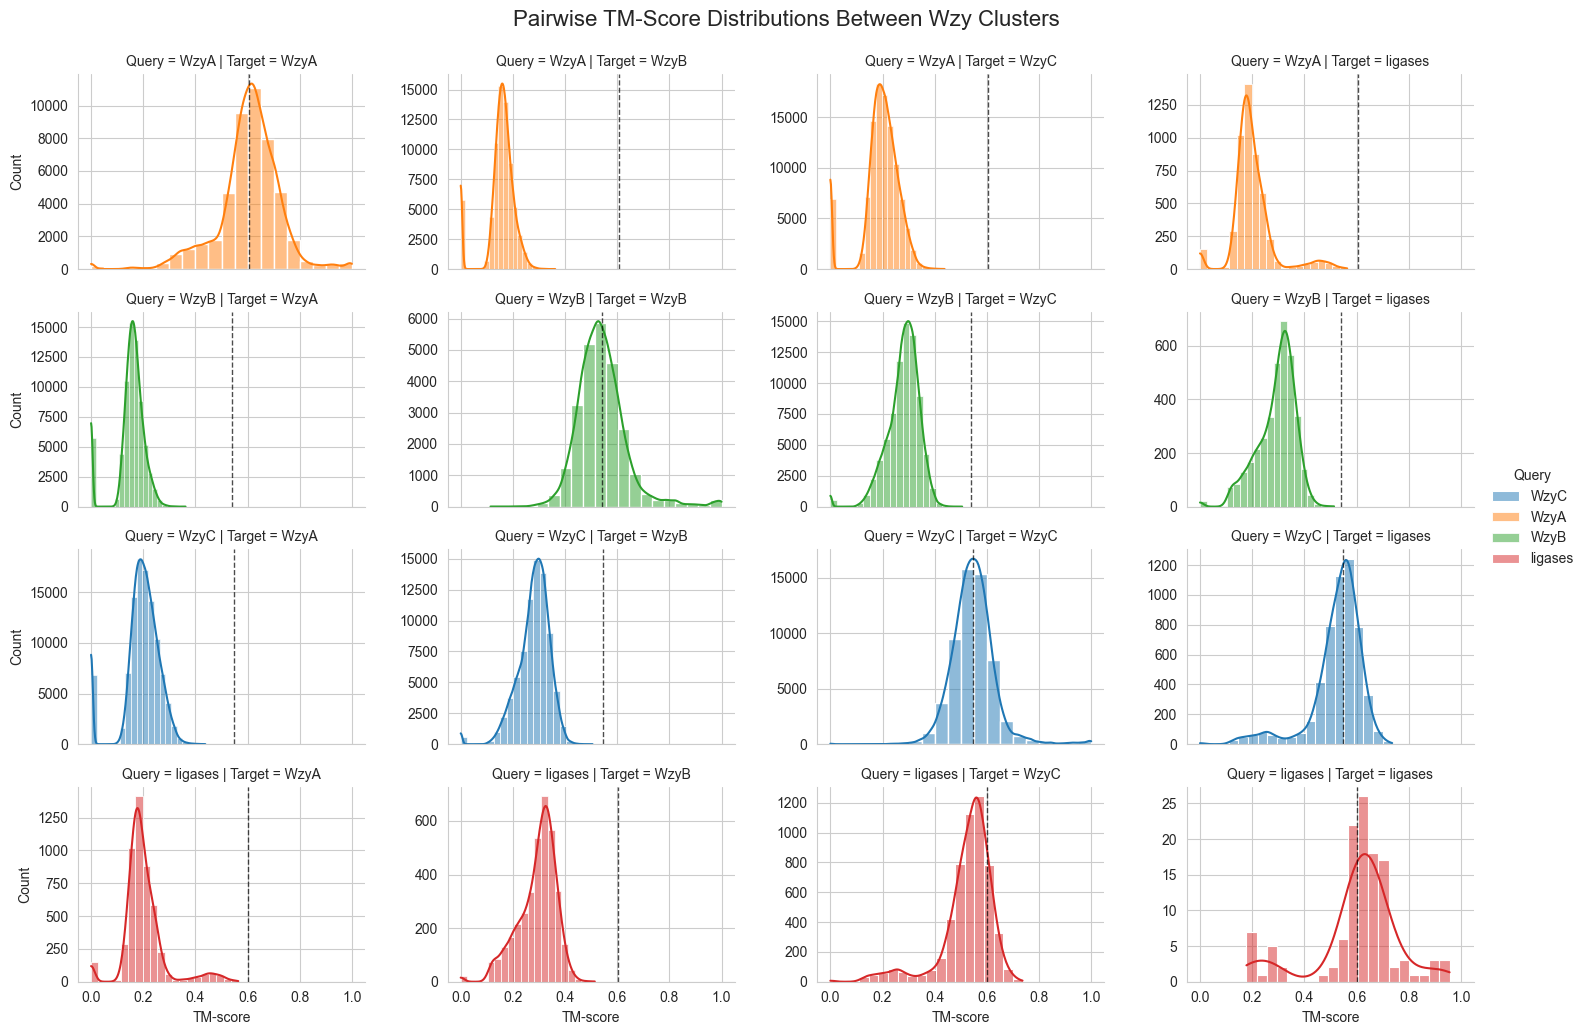

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(group_scores.explode('TM-score'), row='Query', col='Target', hue='Query', sharex=True, sharey=False, aspect=1.5, height=2.5, row_order=target_groups, col_order=target_groups)
g.map(sns.histplot, 'TM-score', bins=20, kde=True)

# Add vertical lines for self-comparison means
for i, row_name in enumerate(g.row_names):
    mean_val = group_score_summary.loc[
        (group_score_summary['Query'] == row_name) & 
        (group_score_summary['Target'] == row_name), 
        'mean'
    ].values[0]
    for ax in g.axes[i]:
        ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7)

g.fig.suptitle('Pairwise TM-Score Distributions Between Wzy Clusters', y=1.03, fontsize=16)
g.set_axis_labels('TM-score', 'Count')
g.add_legend()
plt.show()